# Worldometer COVID-19 Cases

### Calvin D'Souza

---

* Scraped [Worldometer](https://www.worldometers.info/coronavirus/) using BeautifulSoup to get global COVID-19 data
* Cleaned data
* Displayed Cases, Tests, Deaths per 1M for several countries

In [2]:
import requests
from bs4 import BeautifulSoup
# import schedule
import time
import urllib.request
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

In [3]:
page = requests.get("https://www.worldometers.info/coronavirus/")
page

<Response [200]>

In [4]:
soup = BeautifulSoup(page.content, 'html.parser')
table = soup.find("table", class_="table-bordered")
tbody = table.find("tbody", class_=None)

column_header = []
for th in table.find_all('th'):
    column_header.append(th.get_text())


table_rows = tbody.find_all("tr")

data = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    data.append(row)
    
column_header[10] = 'TotCasesPer1Mpop'
print(column_header)

['#', 'Country,Other', 'TotalCases', 'NewCases', 'TotalDeaths', 'NewDeaths', 'TotalRecovered', 'NewRecovered', 'ActiveCases', 'Serious,Critical', 'TotCasesPer1Mpop', 'Deaths/1M pop', 'TotalTests', 'Tests/\n1M pop\n', 'Population', 'Continent', '1 Caseevery X ppl', '1 Deathevery X ppl', '1 Testevery X ppl']


In [5]:
df = pd.DataFrame(data, columns=column_header)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   #                   229 non-null    object
 1   Country,Other       229 non-null    object
 2   TotalCases          229 non-null    object
 3   NewCases            229 non-null    object
 4   TotalDeaths         229 non-null    object
 5   NewDeaths           229 non-null    object
 6   TotalRecovered      229 non-null    object
 7   NewRecovered        229 non-null    object
 8   ActiveCases         229 non-null    object
 9   Serious,Critical    229 non-null    object
 10  TotCasesPer1Mpop    229 non-null    object
 11  Deaths/1M pop       229 non-null    object
 12  TotalTests          229 non-null    object
 13  Tests/
1M pop
      229 non-null    object
 14  Population          229 non-null    object
 15  Continent           229 non-null    object
 16  1 Caseevery X ppl   229 no

In [6]:
# Removing rows that do nnot contain country data
for index, row in df.iterrows():
    if row[0]=='':
        df.drop(index, inplace=True)
    
for index, row in df.iterrows():
    if row[11]=='':
        df.drop(index, inplace=True)
        
for index, row in df.iterrows():
    if row[10]=='':
        df.drop(index, inplace=True)

df = df[:15]

# Reset the index after dropping columns
df = df.reset_index(drop=True)
df.head(15)

,#,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",TotCasesPer1Mpop,Deaths/1M pop,TotalTests,Tests/\n1M pop\n,Population,Continent,1 Caseevery X ppl,1 Deathevery X ppl,1 Testevery X ppl
0,1,USA,"31,983,129","+51,816","576,289",+451,"24,556,179","+74,463","6,850,661","9,203","96,185","1,733","420,653,377","1,265,061","332,516,170",North America,10,577,1
1,2,India,"13,686,073","+160,694","171,089",+880,"12,250,440","+96,727","1,264,544","8,944","9,842",123,"257,806,986","185,397","1,390,568,032",Asia,102,"8,128",5
2,3,Brazil,"13,521,409","+38,866","355,031","+1,738","11,957,068","+76,265","1,209,310","8,318","63,262","1,661","28,600,000","133,809","213,737,070",South America,16,602,7
3,4,France,"5,067,216","+8,536","99,135",+385,"310,934","+1,147","4,657,147","5,916","77,497","1,516","70,140,847","1,072,715","65,386,285",Europe,13,660,1
4,5,Russia,"4,649,710","+8,320","103,263",+277,"4,272,165","+6,656","274,282","2,300","31,851",707,"123,900,000","848,727","145,983,351",Europe,31,"1,414",1
5,6,UK,"4,373,343","+3,568","127,100",+13,"3,981,812","+9,783","264,431",406,"64,159","1,865","136,821,861","2,007,241","68,164,143",Europe,16,536,0
6,7,Turkey,"3,903,573","+54,562","34,182",+243,"3,372,629","+41,218","496,762","2,891","45,900",402,"41,892,922","492,595","85,045,404",Asia,22,"2,488",2
7,8,Italy,"3,779,594","+9,789","114,612",+358,"3,140,565","+18,010","524,417","3,593","62,584","1,898","53,245,501","881,660","60,392,321",Europe,16,527,1
8,9,Spain,"3,370,256","+7,446","76,525",+65,"3,111,026","+15,104","182,705","2,163","72,062","1,636","44,285,495","946,900","46,768,927",Europe,14,611,1
9,10,Germany,"3,021,064","+11,523","79,110",+146,"2,683,900","+12,700","258,054","4,662","35,968",942,"51,559,277","613,852","83,993,045",Europe,28,"1,062",2


In [7]:
df.columns = df.columns.str.replace(' ', '')
df.columns = df.columns.str.replace('/', 'Per')
df.columns = df.columns.str.replace('\n', '')
df.dtypes

#                   object
Country,Other       object
TotalCases          object
NewCases            object
TotalDeaths         object
NewDeaths           object
TotalRecovered      object
NewRecovered        object
ActiveCases         object
Serious,Critical    object
TotCasesPer1Mpop    object
DeathsPer1Mpop      object
TotalTests          object
TestsPer1Mpop       object
Population          object
Continent           object
1CaseeveryXppl      object
1DeatheveryXppl     object
1TesteveryXppl      object
dtype: object

In [8]:
df.rename(columns={'TotCasesPer1Mpop': 'totalCasesPerM', 'Country,Other': 'Country'}, inplace=True)
df.dtypes

#                   object
Country             object
TotalCases          object
NewCases            object
TotalDeaths         object
NewDeaths           object
TotalRecovered      object
NewRecovered        object
ActiveCases         object
Serious,Critical    object
totalCasesPerM      object
DeathsPer1Mpop      object
TotalTests          object
TestsPer1Mpop       object
Population          object
Continent           object
1CaseeveryXppl      object
1DeatheveryXppl     object
1TesteveryXppl      object
dtype: object

In [9]:
# Converting obj to correct types
df['TotalCases'] = df['TotalCases'].str.replace(',', '').astype(int)
df['DeathsPer1Mpop'] = df['DeathsPer1Mpop'].str.replace(',', '').astype(float)
df['TestsPer1Mpop'] = df['TestsPer1Mpop'].str.replace(',', '').astype(float)
df['1CaseeveryXppl'] = df['1CaseeveryXppl'].str.replace(',', '').astype(float)
df['totalCasesPerM'] = df['totalCasesPerM'].str.replace(',', '').astype(float)

df.dtypes

#                    object
Country              object
TotalCases            int64
NewCases             object
TotalDeaths          object
NewDeaths            object
TotalRecovered       object
NewRecovered         object
ActiveCases          object
Serious,Critical     object
totalCasesPerM      float64
DeathsPer1Mpop      float64
TotalTests           object
TestsPer1Mpop       float64
Population           object
Continent            object
1CaseeveryXppl      float64
1DeatheveryXppl      object
1TesteveryXppl       object
dtype: object

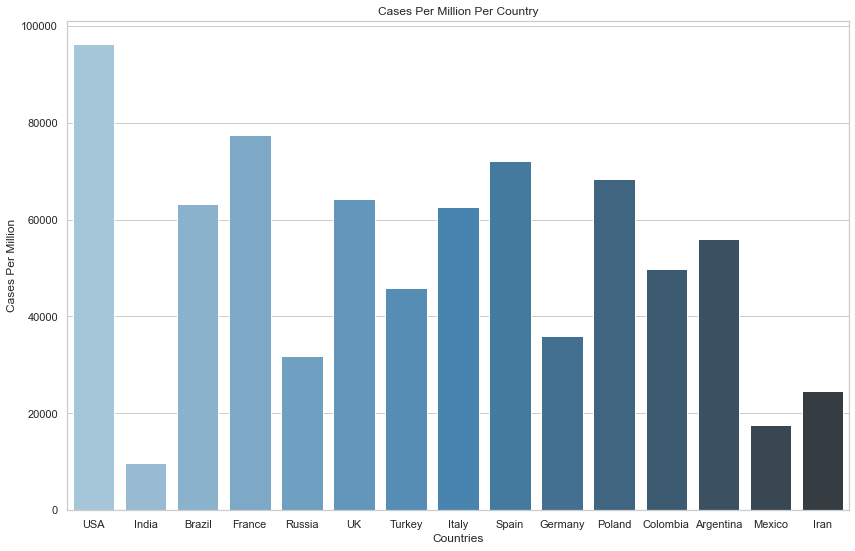

In [16]:
rcParams['figure.figsize'] = 14,9
ax = sns.barplot(x='Country', y='totalCasesPerM', data=df, palette="Blues_d")
ax.set_title("Cases Per Million Per Country")
ax.set_xlabel("Countries")
ax.set_ylabel("Cases Per Million")

# Download graph
plt.savefig('worldometer_cases_per_m.png', bbox_inches='tight')

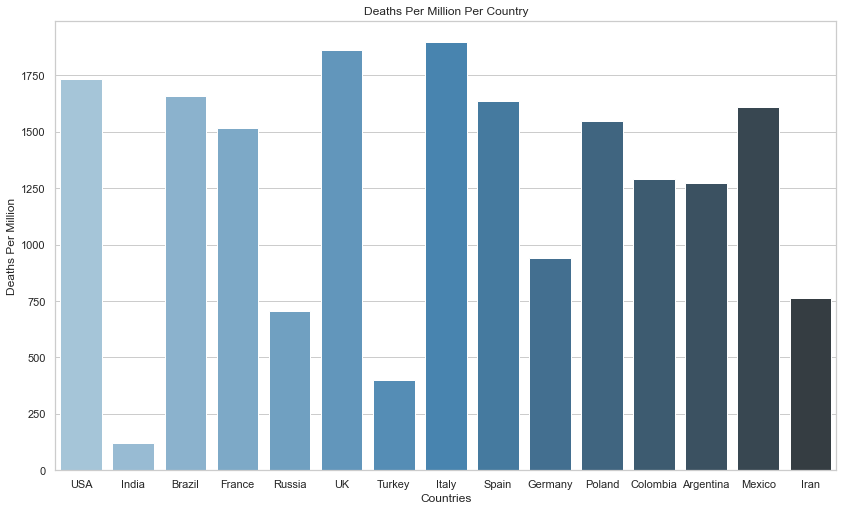

In [12]:
rcParams['figure.figsize'] = 14,9
ax2 = sns.barplot(x='Country', y='DeathsPer1Mpop', data=df, palette="Blues_d")
ax2.set_title("Deaths Per Million Per Country")
ax2.set_xlabel("Countries")
ax2.set_ylabel("Deaths Per Million")

# Download graph
plt.savefig('worldometer_deaths_per_m.png', bbox_inches='tight')

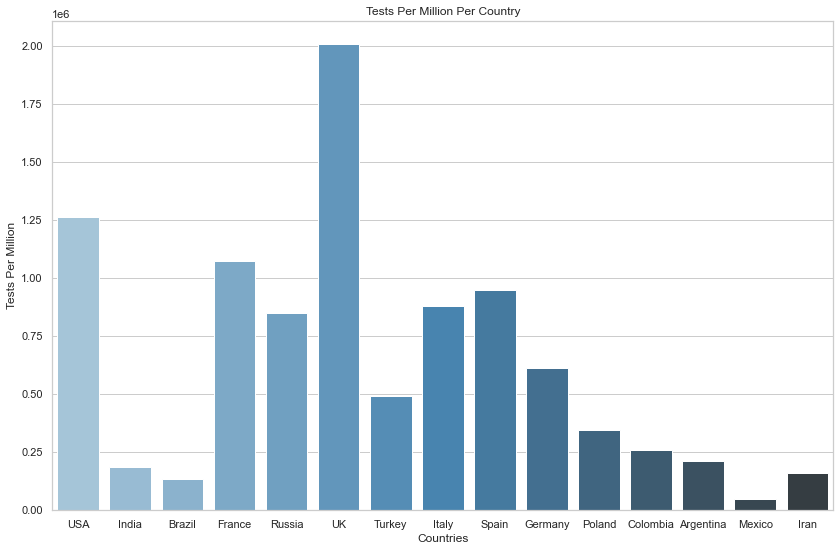

In [13]:
rcParams['figure.figsize'] = 14,9

ax3 = sns.barplot(x='Country', y='TestsPer1Mpop', data=df, palette="Blues_d")
ax3.set_title("Tests Per Million Per Country")
ax3.set_xlabel("Countries")
ax3.set_ylabel("Tests Per Million")

# Download graph
plt.savefig('worldometer_tests_per_m.png', bbox_inches='tight')

In [15]:
# rcParams['figure.figsize'] = 14,9
# ax2 = df.plot.bar(x='Country', y='1CaseeveryXppl', rot=0, title="Cases Per Million Per Country")

# ax2.set_xlabel("Countries")
# ax2.set_ylabel("Cases Per Million")

# plt.show()